# EDA & Data cleaning

In [7]:
import numpy as np
import pandas as pd
import string
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

import helper_functions as hlf
from tqdm import tqdm
%matplotlib inline

In [10]:
data = pd.read_json(r'D:\Amazon_reviews\Electronics.json', lines=True)

## View Data

In [12]:
df = pd.DataFrame(data)
print(df.shape)
df.head()

(1689188, 9)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support",1317254400,"09 29, 2011"


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1689188 entries, 0 to 1689187
Data columns (total 9 columns):
reviewerID        1689188 non-null object
asin              1689188 non-null object
reviewerName      1664458 non-null object
helpful           1689188 non-null object
reviewText        1689188 non-null object
overall           1689188 non-null int64
summary           1689188 non-null object
unixReviewTime    1689188 non-null int64
reviewTime        1689188 non-null object
dtypes: int64(2), object(7)
memory usage: 116.0+ MB


In [4]:
df['overall'].value_counts()

5    1009026
4     347041
3     142257
1     108725
2      82139
Name: overall, dtype: int64

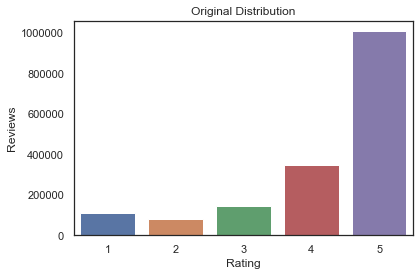

In [5]:
sns.set(style='white')
ax=sns.countplot(x='overall', data=df)

ax.set(xlabel='Rating', ylabel='Reviews')
ax.set(title='Original Distribution')
plt.tight_layout()
# plt.savefig('class_imbalance')

In [6]:
# tuple containing the ratings and the number of reviews to remove
ratings_tuple = [(3,40000),
                 (4,247000),
                 (5,900000)]

# random undersampling
df_final = df.copy(deep=True)
for rating_tuple in ratings_tuple:
    df_final = hlf.remove_reviews(df_final, 'overall', rating_tuple)

(502188, 9)


5    109026
1    108725
3    102257
4    100041
2     82139
Name: overall, dtype: int64

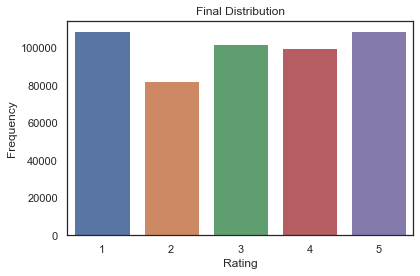

In [7]:
# sanity check - ensure the class imbalance issue was resolved
sns.set(style='white')
ax=sns.countplot(x='overall', data=df_final)

ax.set(xlabel='Rating', ylabel='Frequency')
ax.set(title='Final Distribution')
plt.tight_layout()
# plt.savefig('class_imbalance_fixed')

print(df_final.shape)
df_final['overall'].value_counts()

In [8]:
df_final.reset_index(drop=True, inplace=True)
df_text = df_final.copy(deep=True)[['reviewText','overall']]

## Create Additional Features

In [9]:
# new dataframe for engineered features
df_engineered = pd.DataFrame()

In [10]:
# length of review
df_engineered['review_length'] = df_text['reviewText'].apply(lambda x: len(x))

In [11]:
# word count for review
df_engineered['word_count'] = df_text['reviewText'].apply(lambda x: len(x.split(" ")))

In [12]:
# number of exclamation points
df_engineered['exclamation_count'] = df_text['reviewText'].apply(lambda x: x.count('!'))

In [13]:
# number of question marks
df_engineered['question_count'] = df_text['reviewText'].apply(lambda x: x.count('?'))

In [14]:
# df_engineered.to_csv('df_engineered.csv', index=None, header=True)

# NLP Preprocessing
   1. Lower case 
   2. Remove punctuation
   3. Remove stop words
   4. Tokenize
   5. Lemmatize

In [15]:
# expand list of stopwords to include punctuatuion
new_stopwords = [x.replace("'","") for x in stopwords.words('english')]
final_stopwords = set(new_stopwords + stopwords.words('english') + list(string.punctuation))

In [16]:
# make review text into a series
reviews = df_text['reviewText']

In [28]:
# perform the cleaning, tokenizing, and lemmatizing of each review and save it to corpus
lemmatizer = WordNetLemmatizer() 
corpus = hlf.finalize_token(reviews, final_stopwords, lemmatizer)

100%|█████████████████████████████████████████████████████████████████████████| 502188/502188 [48:08<00:00, 173.88it/s]


In [30]:
# put the corpus in a dataframe
df_corpus = pd.DataFrame(corpus, columns=['reviews'])

In [31]:
# merge corpus into original dataframe
df_reviews_final = pd.concat([df_text, df_corpus], axis=1)

# save final dataframe to csv
df_reviews_final.to_csv('final_df.csv', index=None, header=True)